In [1]:
#Import des librairies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')




In [2]:
#Scraping de données
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('today')

df = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)

In [3]:
# Taille des données
df.shape

(2251, 6)

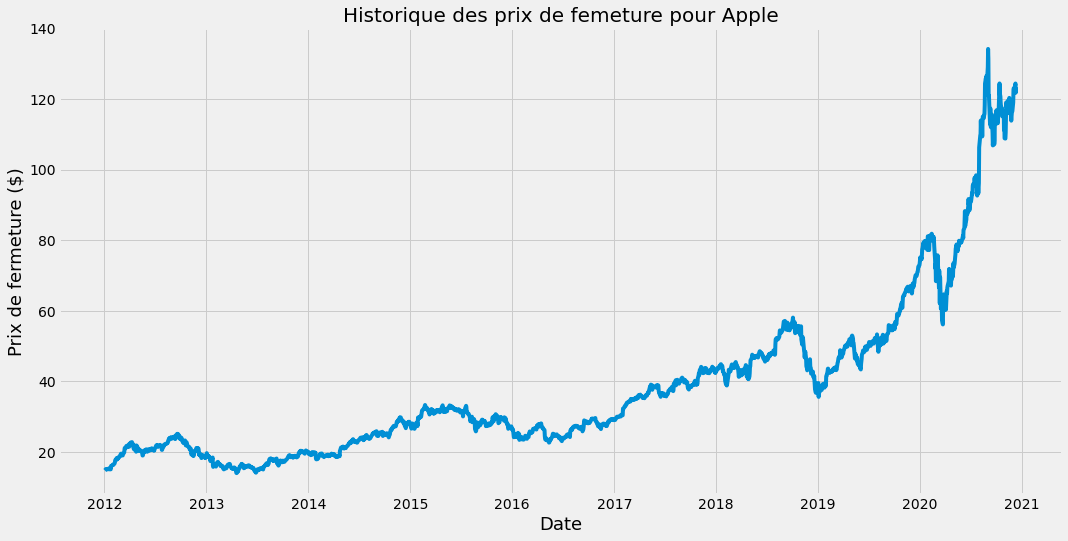

In [4]:
# Visualisation des prix de fermeture
plt.figure(figsize=(16,8))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.show()

In [5]:
#On ne s'intéresse qu'aux prix de fermeture
data = df.filter(['Close'])

#On convertit les données en numpy array
dataset = data.values
#Taille des données d'entraînement
training_data_len = int(len(dataset) * 0.8)
training_data_len


1800

In [6]:
#Normalisation des données
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



In [7]:
#Création des données d'entraînement
train_data = scaled_data[0:training_data_len, :]
#Création de X_train and y_train
X_train = []
y_train = []

for k in range(60,len(train_data)):
    X_train.append(train_data[k-60:k,0])
    y_train.append(train_data[k,0])


In [8]:
#On met les données d'entraînement en numpy array
X_train, y_train = np.array(X_train), np.array(y_train)


In [9]:
#Les données doivent être tridimensionnelles pour notre modèle
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))


In [10]:
#Modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

In [11]:
#Compilation
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Entraînement
model.fit(X_train,y_train, batch_size=10, epochs=20)


Epoch 1/20
174/174 [==============================] - 3s 19ms/step - loss: 8.2215e-04
Epoch 2/20
174/174 [==============================] - 3s 19ms/step - loss: 1.4593e-04
Epoch 3/20
174/174 [==============================] - 3s 19ms/step - loss: 1.2992e-04
Epoch 4/20
174/174 [==============================] - 3s 19ms/step - loss: 1.1080e-04
Epoch 5/20
174/174 [==============================] - 3s 19ms/step - loss: 1.2825e-04
Epoch 6/20
174/174 [==============================] - 3s 19ms/step - loss: 8.8194e-05
Epoch 7/20
174/174 [==============================] - 3s 19ms/step - loss: 7.0702e-05
Epoch 8/20
174/174 [==============================] - 3s 19ms/step - loss: 7.6833e-05
Epoch 9/20
174/174 [==============================] - 4s 20ms/step - loss: 7.9203e-05
Epoch 10/20
174/174 [==============================] - 3s 19ms/step - loss: 7.8616e-05: 0s - loss: 8.
Epoch 11/20
174/174 [==============================] - 4s 21ms/step - loss: 6.0103e-05
Epoch 12/20
174/174 [================

In [13]:
#Création des données de test
test_data = scaled_data[training_data_len - 60: , :]
#Création de X_test et y_test
X_test=[]
y_test = []
y_naif = []

for k in range(60,len(test_data)):
    X_test.append(test_data[k-60:k,0])
    y_test.append(test_data[k,0])
    y_naif.append(test_data[k-1,0])

In [14]:
#On met les données d'entraînement en numpy array
X_test, y_test, y_naif = np.array(X_test), np.array(y_test), np.array(y_naif)


In [15]:
#Les données doivent être tridimensionnelles pour notre modèle
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [16]:
#Prédiction
prediction_scaled = model.predict(X_test)
prediction = scaler.inverse_transform(prediction_scaled)


In [17]:
#Baseline
rmse = np.sqrt(np.mean(y_naif- y_test)**2)
rmse

0.0014744622318708335

In [18]:
#Calcul de l'erreur
prediction_scaled2 = np.reshape(prediction_scaled,y_test.shape)
rmse = np.sqrt(np.mean(prediction_scaled2 - y_test)**2)
rmse

0.016161997730261394

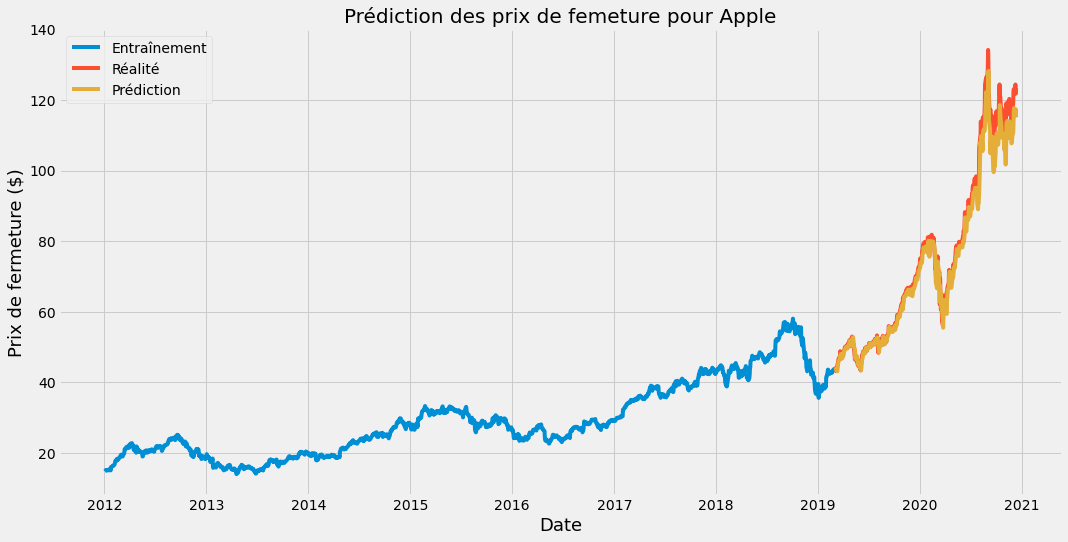

In [29]:
#Visualisation des résultats
train = data[:training_data_len]
test = data[training_data_len:].copy()
test['Prediction']=prediction


plt.figure(figsize=(16,8))
plt.title('Prédiction des prix de femeture pour Apple', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close','Prediction']])
plt.legend(['Entraînement','Réalité','Prédiction'])
plt.show()

In [20]:
#Montée - Descente

delta_reel = []
delta_prediction = []

for k in range (len(y_test)-1):
    delta_reel.append(y_test[k+1] - y_test[k])
    delta_prediction.append(prediction_scaled2[k+1] - y_test[k])

In [21]:
#Evaluation de la prédiction de Montée - Descente
c=0
for k in range (len(delta_reel)):
    if delta_reel[k]*delta_prediction[k] >0:
        c+=1
        
c/len(delta_reel)

0.46444444444444444